<h1>Analyzing Merchant Ships Lost to German U-Boats During WWII</h1>

**Stephen Hornish and Kurt Barsotti**

<h2>Table of Content</h2>

1. [Part 1 Plots and Cluster analysis](#PT1)
    * [Web Scraping](#WS)
    * [Tidying](#TY)
    * [Simple Plot](#SP)
    * [Hypothesis Test/Alan Turning](#HT)
    * [Cluster Analysis](#CA)
2. [Part 2 Optimal Convoy Path](#PT2)
    * [Web Scraping](#WS2)
    * [Tidying](#TY2)
    * [Dijkstras](#DJ)
3. [Conclusion](#Con)

<h2>Introduction</h2>

During World War II, one of the main keys to the German plan involved the use of U-boat submarines to disrupt trade between Allied powers. During the years of World War II, German U-boats sank numerous merchant ships in an attempt to prevent Allied forces and cities from resupplying and to disrupt the economies of Allied nations. Data on the sinking of merchant ships makes this an ideal topics for study in the field of data science.

Our intent in this final tutorial is to examine merchant ship losses during the Second World War and see how strategy changed over time and attempt to find the optimal convoy route throughout the war. Our analysis in Part 1 examines trends of where ships were lost and try to examine how the German U-boat strategy changed as the war progessed and give historical context to the data we observe. In Part 2 we strictly look at convoys in the North Atlantic in an attempt to determine the safety of each convoy route and to try to determine optimal paths to take.

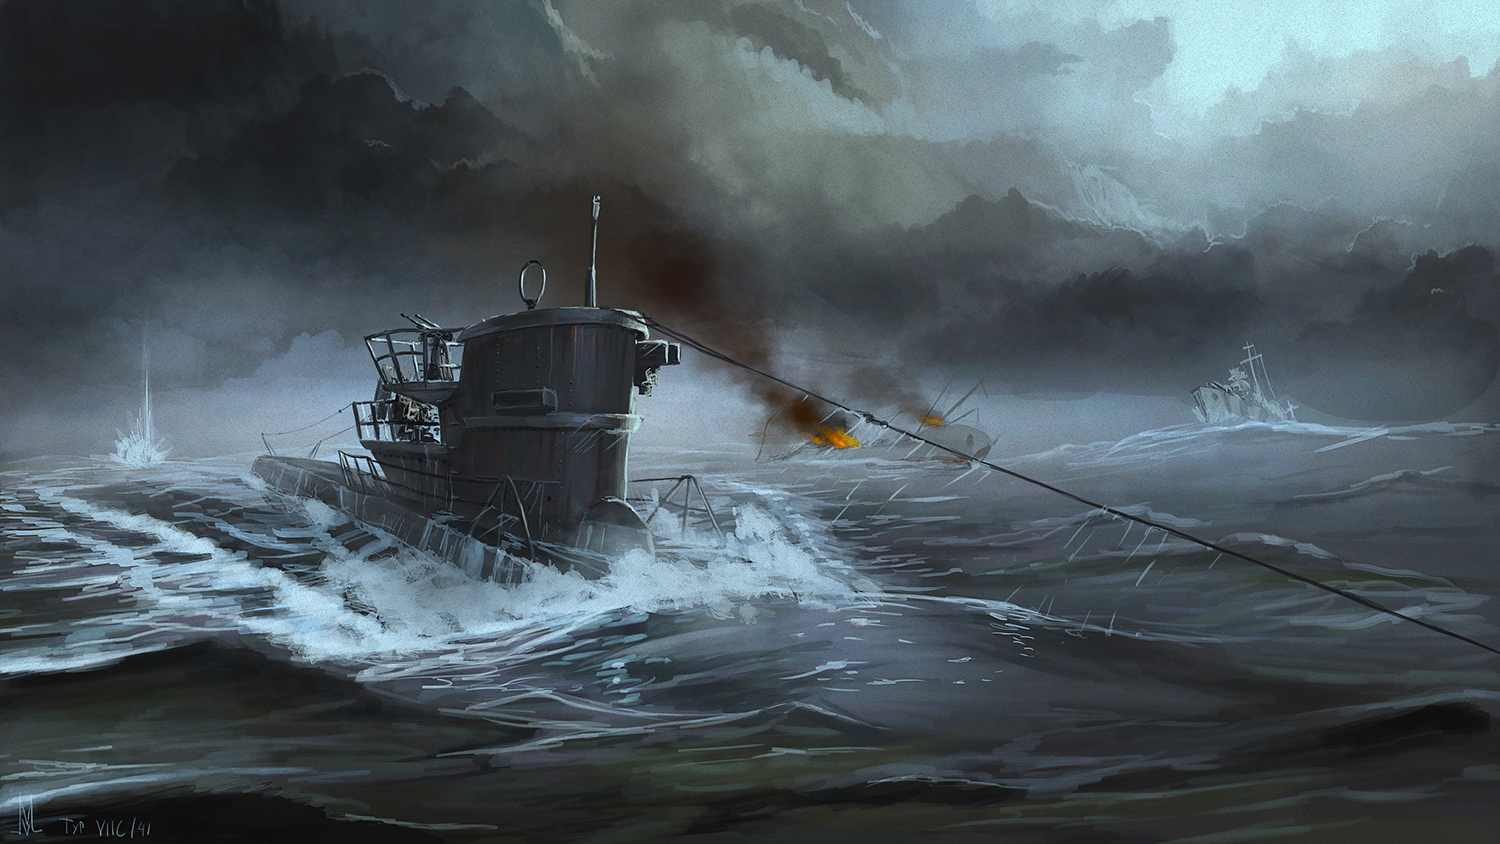

<h2>Setup</h2>

This tutorial is run on Python 3 in a Jupyter notebook. Running the lines below will install and import all necessary modules that are needed to run this tutorial

In [1]:
!pip install geopy
!pip install folium 
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests
import datetime
import matplotlib.pyplot as plt
import json
import re
import urllib.request
import folium
import seaborn as sns
from folium.plugins import MarkerCluster
from queue import PriorityQueue
import matplotlib.patches as mpatches

    100% |████████████████████████████████| 71kB 1.3MB/s ta 0:00:01
    100% |████████████████████████████████| 81kB 1.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for folium ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/04/d0/a0/b2b8356443364ae79743fce0b9b6a5b045f7560742129fde22
Successfully built folium


<h2>Part 1: Plots and Clustering Analysis</h2>
<a id='PT1'></a>


**Merchant Ship loss data scrapping **
<a id='WS'></a>

The data is being scrapped from Uboat.net that archives all data on Uboat activities. The data was particularly difficult to scrape because the tables were divided by links each link corresponded to a month in WW2 and the shipping losses for that month by Uboats. In addition the location of where the sinkings occured were not stored in the table instead they were on a java script map. To get the coordinates we had to use regular expressions to find the information in the java script code. Becuase So much is happening to scrape the information takes approximately 1.5 min. 

In [2]:
data = pd.DataFrame()
#this regex finds the coordinates contained in teh java script
regx = re.compile('\(-?\d+.\d+,-?\d+.\d+\)')  
#outer loop handles the years of war 
for j in range (39,46):
    #inner loop are the months of the war where the talbes are found
    for i in range(1, 13):
        #the war started on September 1 1939 before that there were no losses so we dont search for that data
        if(j == 39 and i < 9):
            continue
        #the war ended in May after that there were no merchant ship losses 
        if(j == 45 and i == 6):
            break
        #i formats the numbers to match the html of the website
        i =  format(i, "02")
        site = "https://www.uboat.net/allies/merchants/losses_year.html?qdate=19"+str(j) + "-" + str(i)
        res = requests.get(site)
        #retrieves the html
        soup = bs(res.content, "html5lib")
        #finds the table
        table1 = soup.find_all(class_= 'table_subtle')
        #table1 = soup.find_all(class_= 'width450')
        #converts table into list of data frame objects
        ed = pd.read_html( str(table1), flavor = "html5lib", header = 0)
        #handles the regex portion 
        request = urllib.request.Request(site)
        response = urllib.request.urlopen(request)
        the_page = response.read().decode('utf-8')
        coordinates = re.findall(regx, the_page)
        frame = ed[0]
        coordinates.pop(0)
        #the last frame contains the total sunk for that month its uneeded data
        frame.drop(frame.tail(2).index,inplace=True)
        frame['Unnamed: 3'] = coordinates
        data = data.append(ed[0],ignore_index = True)    
data.head()

Date U-boat          Commander      Unnamed: 3   Name of ship  \
0  3 Sep 1939   U-30  Fritz-Julius Lemp  (56.73,-14.08)        Athenia   
1  5 Sep 1939   U-47      Günther Prien   (45.48,-9.75)         Bosnia   
2  5 Sep 1939   U-48   Herbert Schultze  (46.38,-14.98)  Royal Sceptre   
3  6 Sep 1939   U-38     Heinrich Liebe  (38.47,-10.83)         Manaar   
4  6 Sep 1939   U-47      Günther Prien  (46.50,-12.00)      Rio Claro   

      Tons  Nat. Convoy Unnamed: 8  
0  13581.0   NaN     br        NaN  
1   2407.0   NaN     br        NaN  
2   4853.0   NaN     br        NaN  
3   7242.0   NaN     br        NaN  
4   4086.0   NaN     br        NaN

**Tidying**
<a id='TY'></a>

The data we pulled has alot of issues. First, the table columns do not allign with their values, for example Nationality is all Nan and convoy contains the Nationality. In addition the coordinates have parenthesis, for it to be usable we have to split the coordinates up into a latitude and longitutde columns. Once we establish the correct columns we can drop our old one since it is no longer of use.

In [3]:
#the Nat data was nan because how it was formatted 
data = data.drop(['Nat.'], axis=1)
#renames the columns to the correct values
data.columns = ['Date', 'U-boat','Commander','Location','Name of Ship','Tons','Nationality','Convoy']
#converts date to date time so we can plot it 
data['Date'] = pd.to_datetime(data['Date'])
#creates a new column with cumulative sum
data['cumulative_sum'] = data.Tons.cumsum()
#Tidying the data to plot on to a map we must break up the locaiton coodiantes into their own columns
#regex to break up latitude and longitude
regx = re.compile('\((-?\d+.\d+),(-?\d+.\d+)\)')
#function that places matching groups into latitue and longitude
def test(x):
    y = re.match(regx,x['Location'])
    x['latitude'] = float((y[1]))
    x['longitude'] = float((y[2]))  
    return x   
#apply function 
data = data.apply(test,axis= 1)
#drop location since it is no longer needed 
data = data.drop(['Location'], axis=1)
data.head()

Date U-boat          Commander   Name of Ship     Tons Nationality  \
0 1939-09-03   U-30  Fritz-Julius Lemp        Athenia  13581.0          br   
1 1939-09-05   U-47      Günther Prien         Bosnia   2407.0          br   
2 1939-09-05   U-48   Herbert Schultze  Royal Sceptre   4853.0          br   
3 1939-09-06   U-38     Heinrich Liebe         Manaar   7242.0          br   
4 1939-09-06   U-47      Günther Prien      Rio Claro   4086.0          br   

  Convoy  cumulative_sum  latitude  longitude  
0    NaN         13581.0     56.73     -14.08  
1    NaN         15988.0     45.48      -9.75  
2    NaN         20841.0     46.38     -14.98  
3    NaN         28083.0     38.47     -10.83  
4    NaN         32169.0     46.50     -12.00

**Simple Plots**
<a id='SP'></a>


Plot 1:

The first plot shows the tonnage lost per month of the war. Germans commanders measured their success on a patrol by the amount of tonnage sunk not the number of vessels destroyed. This is because sinking 5 small fishing vessels was not as large of a contribution to the war effort as sinking 1 large oil tanker. Interesting observations can be seen from this data the first thing that struck me was the number of tons sunk during the winter was considerably lower then the other seasons. This is because the weather in the North Atlantic is particularly bad in the winter allowing for fewer patrols. Also our data suggests that Uboats were most effective during two points mid 1940 - 1941 and 1942-1943; after these times they failed to sink large amount of materials especially after 1944 when the tonnage and number of ships entering the Uk was at it's highest. 

Plot 2: 

Plot two shows the cummulative sum of tonnage lost. It shows the change over time of what the total number of tons was sunk during the war. This data matches plot one and shows that the slope or rate is steapest from 1942-1943.

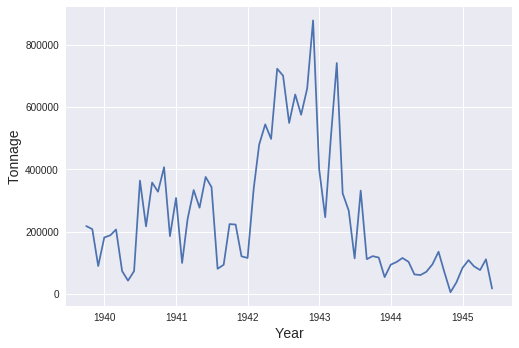

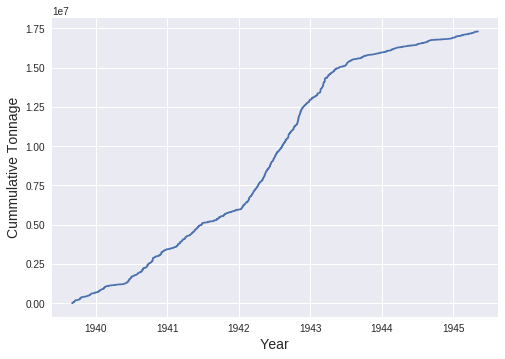

In [4]:
dfty= pd.DataFrame()
# Create a column from the datetime variable
dfty['datetime'] = data["Date"]
dfty['Tons'] = data["Tons"]
dfty.index = dfty['datetime'] 
dfty = dfty.groupby(pd.TimeGrouper('M')).sum()
#Data on uboat losses from uboat.net it was easier to copy in values than scrape for them based on number of values and 
#how there website was set up in this instance
dfty['ubl'] = [2,5,1,1,2,5,3,4,1,1,2,2,1,1,2,0,0,0,5,2,1,4,0,4,2,2,5,10,3,2,7,2,4,3,12,9,10,16,13,5,7,18,15,17,42,16,38,25,10,26,19,8,14,22,24,21,23,24,23,32,20,9,7,15
,14,21,29,48,24]
#adds axis lables
plt.xlabel('Year', fontsize=14)
plt.ylabel('Tonnage', fontsize=14)
plt.plot(dfty.index,dfty.Tons)
plt.show()
#adds axis lables
plt.xlabel('Year', fontsize=14)
plt.ylabel('Cummulative Tonnage', fontsize=14)
plt.plot(data['Date'], data['cumulative_sum'])
plt.show()

**Changing the tide of war Hypothesis Testing**
<a id='HT'></a>


Alan Turning the father of modern computing has often times been attributed to saving Britian from being cut off by the U-boat threat through the use of computer science. Alan Turning and his team worked to develop a machine known as the Bombe that decrypted U-boat Enigma machines which is how U-boats communicated with each other. Our Hypothesis is that upon the cracking of Uboat codes on July 9th 1941 that less merchant ships would be sunk as a result. 

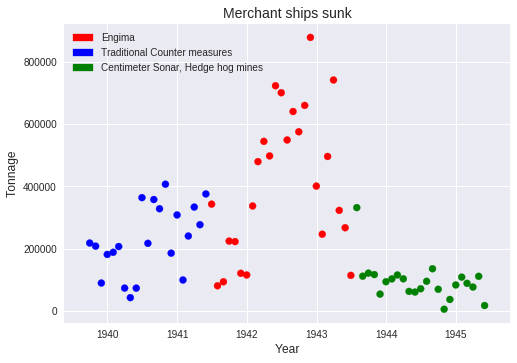

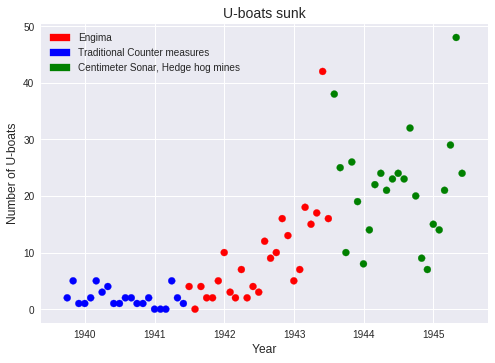

In [5]:
#colors everything before creation of enigma blue everything after red
col = np.where(dfty.index < '1941-06-30','b','r')
#colors everything after late 1943 when both centimetric radar and hedgehogs were introduced
for i in range(0,len(col)):
    if i > 45:
        col[i] = 'g'
#scatter plot
plt.scatter(dfty.index,dfty.Tons, c = col)
#creates color lables for legend
blue_patch = mpatches.Patch(color='b', label='Traditional Counter measures')
red_patch = mpatches.Patch(color='r', label='Engima')
green_patch = mpatches.Patch(color='g', label='Centimeter Sonar, Hedge hog mines')
plt.legend(handles=[red_patch,blue_patch,green_patch])
#adds x and y axis
plt.xlabel('Year', fontsize=12)
plt.ylabel('Tonnage', fontsize=12)
#adds title
plt.title('Merchant ships sunk',fontsize=14)
plt.show()

#creates color lables for legend
blue_patch = mpatches.Patch(color='b', label='Traditional Counter measures')
red_patch = mpatches.Patch(color='r', label='Engima')
green_patch = mpatches.Patch(color='g', label='Centimeter Sonar, Hedge hog mines')
plt.legend(handles=[red_patch,blue_patch,green_patch])
plt.scatter(dfty.index,dfty.ubl, c = col)
#adds x and y axis
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of U-boats', fontsize=12)
#adds title
plt.title('U-boats sunk',fontsize=14)
plt.show()

Number of Uboats on Patrol at any given point
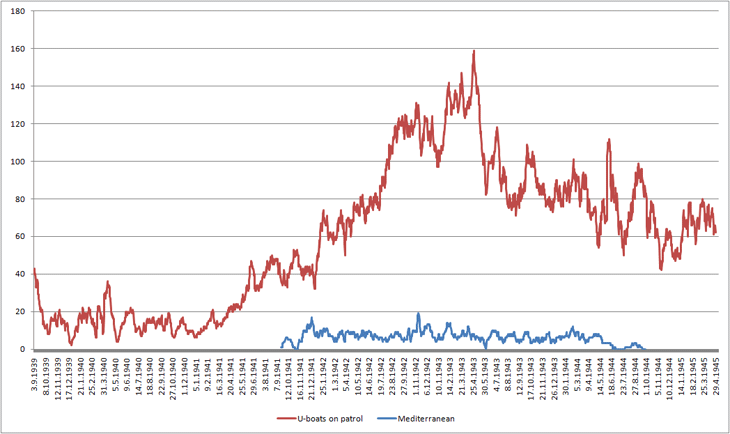

This Graph is not one we created it is from uboats.net. The website does not have public tables stating the number of U-boats on patrol at any given time so I was unable to scrape this information

**Hypothesis Conclusion**

Our results were quite surprising it showed that the creation of Enigma positively correlated to more merchant ships lost during the war. However this is not the entire picture.Onthe out break of the second world war Germany only had 36 U-boats. During the years of 1940 - 1943 more than 500 U-boats were built with the average patrol size increasing from 40 U-boats in 1940 to 140+ U-boats in 1943. The number of active U-boat patrols is more correlated to the number of  merchant ships sunk than the counter measures put into place. It is only when a critical number of U-boats are destroyed that fewer go on pratrol and the tide of the war begins to turn against U-boats. Enigma and other technologies did not save merchant ships they helped sink U-boats, as the second graph shows. With fewer U-boats on patrol as the war progresses, less merchant tonnage was lost. 




**Cluster Analysis PT 1**
<a id='CA'></a>

This is a cluster map dispicting where Merchant Ships sunk during the second world war from beginning to end. This map indicates that if you were to be a incharge of defending against U-boats you would focus all your attendion on the Area around the british Isles. This is true looking at the war as a whole but in reality, strategy changes over time. The next layered maps depict the war year by year from 1939 - 1945. As the war progressess it is observed that uboat sinkings occur further and furter away from the British Isles 

In [6]:
locations = data[['latitude', 'longitude']]
allmap = folium.Map(location=[46.219374, -19.511719], zoom_start=2)
marker_cluster= MarkerCluster()

locationlist = locations.values.tolist()
for point in range(0,3472):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
allmap.add_child(marker_cluster)

**Cluster Analysis PT 2**

Instructions:

This map depicts the clusters assocatied with each year of the war to switch years simply hover over the button in the top right and select the year you want to view. 

Observations:

It is observed as the war progresses that sinkings occur further from the british isles and are clustered all over the world. This can be explained by the fact that the Home Fleet of the British navy was extremely powerful and began to take the threats of U-boats very seriously. U-boats as a result had to counter the Home Fleet and go further way from England. England was an Island nation with a vast empire feeding it Materials to support the war effort along with beginning to recieve lend lease from the United States. U-boat commanders as a result began to hunt out side the ports of where the ships were leaving and in the middle of the Atlantic. 

In [7]:
#mapping data
locations = data[['latitude', 'longitude']]
locationlist = locations.values.tolist()

#puts the start point of the map in the middle of the atlantic
yearmap = folium.Map(location=[46.219374, -19.511719], zoom_start=2)

#creates feature groups allowing layering on the map
fg39=folium.FeatureGroup(name="1939")
fg40=folium.FeatureGroup(name="1940")
fg41=folium.FeatureGroup(name="1941")
fg42=folium.FeatureGroup(name="1942")
fg43=folium.FeatureGroup(name="1943")
fg44=folium.FeatureGroup(name="1944")
fg45=folium.FeatureGroup(name="1945")

#creates a cluter object and adds it to its respective layer
marker_cluster39 = MarkerCluster().add_to(fg39)
marker_cluster40 = MarkerCluster().add_to(fg40)
marker_cluster41 = MarkerCluster().add_to(fg41)
marker_cluster42 = MarkerCluster().add_to(fg42)
marker_cluster43 = MarkerCluster().add_to(fg43)
marker_cluster44 = MarkerCluster().add_to(fg44)
marker_cluster45 = MarkerCluster().add_to(fg45)
#1939
for point in range(0, 165):
    folium.Marker(locationlist[point]).add_to(marker_cluster39)
#1940
for point in range(166,729):
    folium.Marker(locationlist[point]).add_to(marker_cluster40)
#1941
for point in range(728,1229):
    folium.Marker(locationlist[point]).add_to(marker_cluster41)
#1942
for point in range(1229,2549):
    folium.Marker(locationlist[point]).add_to(marker_cluster42)
#1943
for point in range(2549,3131):
    folium.Marker(locationlist[point]).add_to(marker_cluster43)
#1944
for point in range(3131,3374):
    folium.Marker(locationlist[point]).add_to(marker_cluster44)
#1945
for point in range(3374,3472):
    folium.Marker(locationlist[point]).add_to(marker_cluster45)
    
#adds each cluster figure to the map 
yearmap.add_child(fg39)
yearmap.add_child(fg40)
yearmap.add_child(fg41)
yearmap.add_child(fg42)
yearmap.add_child(fg43)
yearmap.add_child(fg44)
yearmap.add_child(fg45)
yearmap.add_child(folium.LayerControl())

yearmap

<h2>Part 2: Optimal Convoy Paths</h2>
<a id='PT2'></a>


**Data Collection via Web scraper**
<a id='WS2'></a>


In order to determine the safety of routes, we need more data in addition that that gathered in the previous section. A Wikipedia table at https://en.wikipedia.org/wiki/List_of_Allied_convoys_during_World_War_II_by_region contains Convoy codes, their meanings, and the number of trips that were taken along each convoy route. Using a simple web scraper, this data can be accessed and stored in a pandas dataframe.

In [8]:
#Get request to wikipedia
res = requests.get("https://en.wikipedia.org/wiki/List_of_Allied_convoys_during_World_War_II_by_region")


#retrieves the hmtl
soup = bs(res.content, "html5lib")
#finds the table
table1 = soup.find_all(class_= 'wikitable')

#converts table into list of data frame objects
ed = pd.read_html( str(table1), flavor = "html5lib", header = 0)
#grabs the second object from the list (the one we want)
df = ed[1]

df.head()


Code Prefix                         North Atlantic Routes  First Sailing  \
0          AT                United States to British Isles     March 1942   
1         BHX                          Bermuda to Liverpool       May 1940   
2          CK   Charleston, South Carolina to British Isles           1944   
3          CT                       British Isles to Canada           1941   
4          CU  Caribbean (later New York City) to Liverpool  20 March 1943   

  Last Sailing Number of Convoys  \
0         1945               NaN   
1   March 1941     97 (# 41-137)   
2         1944               NaN   
3         1941               NaN   
4  30 May 1945                73   

                                               Notes  
0                                         troopships  
1  sailed from Bermuda and merged with same numbe...  
2                                        rarely used  
3                                         troopships  
4  14-knot convoys of tankers with some fast carg...

**Data Tidying**
<a id='TY2'></a>


Rows without a value for number of convoys are dropped, as they cannot be used to calculate the probability of a ship being sunk. New columns are made for the Start and End locations, and this information is then taken by splitting the North Atlantic Routes Column, which is then dropped as it is no longer useful. The columns for Notes, First Sailing, and Last Sailing are unnecessary and are therefore dropped. Finally, data in the Number of Convoys, Start, and End columns is cleaned so that all values are in a uniform format that is easy to work with.

In [9]:
#drop null rows for number of convoys
df = df[pd.notnull(df['Number of Convoys'])]

#create new columns
df['Start'] = 'NaN'
df['End'] = 'NaN'

#loop through rows
for index, row in df.iterrows():
    
    #split and tidy routes column
    stops = row['North Atlantic Routes'].split(' to ')
    if '(' in stops[0]:
        stops[0] = stops[0][:stops[0].index('(')-1]   
    if '(' in stops[1]:
        stops[1] = stops[1][:stops[1].index('(')-1]
    if 'or' in stops[0]:
        stops[0] = stops[0][:stops[0].index('or')-1]   
    if 'or' in stops[1]:
        stops[1] = stops[1][:stops[1].index('or')-1]
    if ',' in stops[0]:
        stops[0] = stops[0][stops[0].index(',')+2:]  
        
    #store start and end points 
    row['Start'] = stops[0]
    row['End'] = stops[1]

    #Tidy number of convoys columns
    if isinstance(row['Number of Convoys'], str) and '(' in row['Number of Convoys']:
        row['Number of Convoys'] = row['Number of Convoys'][:row['Number of Convoys'].index('(')-1]
        row['Number of Convoys'] = int(row['Number of Convoys'])
    
#drop unnecessary rows
df = df.drop('North Atlantic Routes', axis=1)
df = df.drop('Notes', axis=1)
df = df.drop('First Sailing', axis=1)
df = df.drop('Last Sailing', axis=1)

df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Code Prefix Number of Convoys          Start             End
1         BHX                97        Bermuda       Liverpool
4          CU                73      Caribbean       Liverpool
5         GUF                22  Mediterranean  Chesapeake Bay
6         GUS                92  Mediterranean  Chesapeake Bay
7          HG                89      Gibraltar       Liverpool

We must also clean the data that we acquired in Part 1 so that it is suitable to be used in this section. Rows without data for the Convoy column contain no information about the path that the ships were travelling, and therefore are dropped, as they cannot be used. Convoys with non-standard names are also dropped, as they are not found in the wikipedia data. Any duplicate convoy entries are dropped. This is because for the purposes of this tutorial, we are only interested in if a convoy was attacked, rather than how many ships were lost in an attack. If multiple ships were lost in an attack, it should only be counted once. Finally, numbers are removed from the Convoy column, leaving only the identifying Convoy code.

In [10]:
#create new dataframe with rows from part 1 dataframe with convoy data
sunk_df = data[data.Convoy.notnull()].astype(str)

#drop nonstandard convoy rows
sunk_df = sunk_df[sunk_df['Convoy'].str.contains('-')]

#drop duplicates
sunk_df = sunk_df.drop_duplicates('Convoy')

#remove numbers
for index, row in sunk_df.iterrows():
    st = row['Convoy']
    row['Convoy'] = str(st)[:str(st).index('-')]

sunk_df.head()

Date U-boat          Commander    Name of Ship     Tons Nationality  \
36  1939-09-21   U-35        Werner Lott   Teakwood (d.)   6014.0          br   
60  1939-10-12   U-48   Herbert Schultze    Emile Miguet  14115.0          fr   
61  1939-10-13   U-42           Rolf Dau  Stonepool (d.)   4803.0          br   
63  1939-10-13   U-48   Herbert Schultze       Louisiane   6903.0          fr   
64  1939-10-14   U-45  Alexander Gelhaar        Bretagne  10108.0          fr   

   Convoy cumulative_sum latitude longitude  
36     OA       188556.0    49.65     -6.65  
60     KJ       270090.0    50.25    -14.83  
61     OB       274893.0    48.67     -15.5  
63     OA       286998.0    50.23    -15.33  
64    KJF       297106.0    50.33    -12.75

**Data Analysis**

In this section we aim to calculate the probability that a convoy along a given path would sink. The following steps are taken:

<ol>
    <li>A map is created that maps Convoy name to the number of times that name appears in the sinking dataframe</li>
    <li>Gives the same name to points in the same area (Ex: Bermuda -> Caribbean, Halifax Harbour -> Nova Scotia)</li>
    <li>Adds the number of times sunk to the other dataframe, so that the number of times sailed and number of times sunk are in the same location</li>
    <li>Performs a group by operation on the Start and End fields to find the sum over all routes with the same start and end</li>
    <li>Creates a new column for probability of sinking, calculated as Times Sunk / Number of Convoys</li>
    <li>Adds zero probability routes between Caribbean, Chesapeake Bay, and Nova Scotia. The same is done for Scotland and Liverpool. This is done because there is no data for these routes ships would safely be able to sail them as the could stay in Allied controlled waters in sight of shore for the voyage</li>
    <li>Unnecessary columns are then dropped</li>
</ol>

In [11]:
#number of instances of each convoy
times_sunk = sunk_df.Convoy.value_counts()

#Give same name to points in same place
df = df.replace(['Bermuda', 'Halifax Harbour', 'Firth of Clyde'], ['Caribbean', 'Nova Scotia', 'Scotland'])
df['Times Sunk'] = 'NaN'

#loop through rows
for index, row in df.iterrows():
    #store number of times sunk
    row['Number of Convoys'] = int(row['Number of Convoys'])
    if row['Code Prefix'] in times_sunk:
        row['Times Sunk'] = int(times_sunk[row['Code Prefix']])
    else:
        row['Times Sunk']=0
        
#groupby start, end: sum on times sunk, number of convoys
df2 = df.groupby(['Start', 'End'])[['Times Sunk', 'Number of Convoys']].sum()
df2['Prob_sunk'] = 'NaN'

#calculate probability of sinking
for index, row in df2.iterrows():
    df2.set_value(index, 'Prob_sunk' , float(row['Times Sunk']) / float(row['Number of Convoys']))
    
#remove rows with 100% probability of sinking
df2 = df2[df2.Prob_sunk != 1]

df2 = df2.reset_index()

#add 0 weight edges
df_add = pd.DataFrame({'Start': ['Nova Scotia', 'Chesapeake Bay', 'Chesapeake Bay', 'Caribbean', 'Scotland', 'Liverpool'],
                       'End': ['Chesapeake Bay', 'Nova Scotia', 'Caribbean', 'Chesapeake Bay', 'Liverpool', 'Scotland'],
                       'Prob_sunk': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]})

df2 = df2.append(df_add).reset_index()

#drop unnecessary rows
df2 = df2.drop(['Number of Convoys', 'Times Sunk'], axis = 1)

df2

index             End  Prob_sunk           Start
0       0       Liverpool  0.0294118       Caribbean
1       1   Mediterranean  0.0940171  Chesapeake Bay
2       2       Liverpool   0.146067       Gibraltar
3       3       White Sea        0.4         Iceland
4       4       Caribbean  0.0140845       Liverpool
5       5       Gibraltar   0.210526       Liverpool
6       6   Mediterranean   0.112245       Liverpool
7       7     Nova Scotia   0.189944       Liverpool
8       8    Sierra Leone   0.152672       Liverpool
9       9  Chesapeake Bay  0.0614035   Mediterranean
10     10       Liverpool   0.106796   Mediterranean
11     11        Scotland  0.0666667   Mediterranean
12     12       Liverpool   0.218914     Nova Scotia
13     13   Mediterranean  0.0444444        Scotland
14     14       Liverpool   0.157303    Sierra Leone
15     15         Iceland   0.266667       White Sea
16     16        Scotland   0.529412       White Sea
17      0  Chesapeake Bay          0     Nova Scotia
18      1     Nova Scotia          0  Chesapeake Bay
19      2       Caribbean          0  Chesapeake Bay
20      3  Chesapeake Bay          0       Caribbean
21      4       Liverpool          0        Scotland
22      5        Scotland          0       Liverpool

**Modified Dijkstra's Algorithm**
<a id='DJ'></a>

The following is a modified version of Dijkstra's algorithm, which we will use to calculate optimal paths between locations. A simplified version of the algorithm is as follows:
<ol>
    <li>Add the start city to a priority queue with distance 0</li>
    <li>Add all other cities to a priority queue with distance 1 (essentially infinity in the case of probability)</li>
    <li>While the queue is not empty:</li>
        <ul>
            <li>Remove first non-visited item</li>
            <li>Mark as visited</li>
            <li>Calculate the new distance of all neighbors. This probability = p(a) + p(b) - p(a)p(b), where a is the likelihood of a ship sinking on the way to the current node, and p(b) is the likelihood of sinking between the current node and its neighbor. Update the weights of neighbors in the priority queue.</li>
        </ul>
    <li>Pass final information on distances and predecessors to another function which returns a pandas dataframe with information about optimal paths</li>
</ol>

In [12]:

def dijkstras(adj_list, s):
    
    #distances map
    dist = {}
    dist[s] = 0.0
    
    #init priority queue
    q = PriorityQueue()
    
    #add start with distance 0
    q.put((0.0, s))
    
    prev = {s:s}
    
    #create set of visited nodes
    visited = set([])
    
    #add all nodes to queue with weight 1 (infinity)
    for a in adj_list.keys():
        if a != s:
            dist[a] = 1.0
            q.put((1.0, s))
            prev[a] = ''
        
    while not q.empty():
        #get next non-visited element
        curr = q.get()
        if curr[1] not in visited:
            #mark as visited
            visited.add(curr[1])
            #for all neighbors
            for n in adj_list[curr[1]]:
                #calculate possible new distance
                dc = dist[curr[1]] + n[1] - (dist[curr[1]]*n[1])
                
                #if new distance less than previous
                if dc < dist[n[0]]:
                    #update distance, predecessor, add to priority queue
                    dist[n[0]] = dc
                    prev[n[0]] = curr[1]
                    q.put((dc, n[0]))
    #create pandas dataframe and return
    return make_dijkstra_df(dist, prev, s)

def make_dijkstra_df(dist, prev, s):
    #elements in each column
    points = [po for po in dist.keys()]
    dists = [dist[po] for po in points]
    paths = []

    #create path strings
    for po in points:
        
        path = []
        #get predecessor
        c_prev = prev[po]
        
        #if there is no existing path
        if c_prev == '':
            paths += ['No Path']
        else:
            #add predecessors to stack until start city is reached
            while True:
                path.append(c_prev)
                if c_prev == s:
                    break
                c_prev = prev[c_prev]

            pathstr = ''
            
            #pop off of stack and add to string
            while len(path) > 1:
                pathstr = pathstr + path.pop() + ' -> '
            pathstr += path.pop()
            #add to array
            paths += [pathstr]
            
    #construct dataframe
    df_dij = pd.DataFrame({'Endpoint': points,
                       'Sinking Probability': dists,
                       'Optimal Path': paths})
    return df_dij


**Example routes**

Below, an adjacency list is made for the data. This is then passed to Dijkstra's algorithm for 2 example source cities

In [13]:
#adjacency list
a = {}

for index, row in df2.iterrows():
    st = row['Start']
    e = row['End']
    p = row['Prob_sunk']
    #if entry exists already for start in adjacency list, add new entry with endpoint / weight
    if row['Start'] in a:
        a[st] += [[e, p]]
        
    #if no entry for start in adjacency list, create entry with endpoint / weight
    else:
        a[st] = [[e,p]]

#Example run with liverpool
df_liv = dijkstras(a, 'Liverpool')

df_liv


Endpoint                              Optimal Path  \
0       Liverpool                                 Liverpool   
1       Caribbean                                 Liverpool   
2  Chesapeake Bay                    Liverpool -> Caribbean   
3       Gibraltar                                 Liverpool   
4         Iceland                                   No Path   
5   Mediterranean                     Liverpool -> Scotland   
6     Nova Scotia  Liverpool -> Caribbean -> Chesapeake Bay   
7        Scotland                                 Liverpool   
8    Sierra Leone                                 Liverpool   
9       White Sea                                   No Path   

   Sinking Probability  
0             0.000000  
1             0.014085  
2             0.014085  
3             0.210526  
4             1.000000  
5             0.044444  
6             0.014085  
7             0.000000  
8             0.152672  
9             1.000000

In [14]:
#example run with chesapeake bay
df_chesapeake = dijkstras(a, 'Chesapeake Bay')

df_chesapeake

Endpoint                                       Optimal Path  \
0  Chesapeake Bay                                     Chesapeake Bay   
1       Caribbean                                     Chesapeake Bay   
2       Gibraltar           Chesapeake Bay -> Caribbean -> Liverpool   
3         Iceland                                            No Path   
4       Liverpool                        Chesapeake Bay -> Caribbean   
5   Mediterranean  Chesapeake Bay -> Caribbean -> Liverpool -> Sc...   
6     Nova Scotia                                     Chesapeake Bay   
7        Scotland           Chesapeake Bay -> Caribbean -> Liverpool   
8    Sierra Leone           Chesapeake Bay -> Caribbean -> Liverpool   
9       White Sea                                            No Path   

   Sinking Probability  
0             0.000000  
1             0.000000  
2             0.233746  
3             1.000000  
4             0.029412  
5             0.072549  
6             0.000000  
7             0.029412  
8             0.177593  
9             1.000000

**Analysis**

Start points of Liverpool and the Chesapeake Bay are chosen for example runs. These locations were chosen as their central positions in England and the United States would make then centers of trade from which it would be important to have safe access to many locations.<br><br>

Studying the Liverpool data, it was found that it would be safer to access the Mediterannean from Scotland rather than by going straight from Liverpool. This is likely because Liverpool would be a center of trade for England, and therefore a more obivous targer for U-boats. An attacker would be much more likely to look for ships from a trade center rather than from Scotland. Another finding is that it would be safer to access Nova Scotia by sailing first to the Caribbean, then up the East Coast of North America. Nova Scotia and England are in a similar position with regards to latitude, and therefore Germans would more heavily patrol this area, as it is a straight path. By taking a less expected path, travel could be safer.

The Chesapeake Bay data routes much of its traffic through Liverpool. This is likely an issue of not enough data. Many of the routes for which data is available involve Liverpool, and therefore the algorithm heavily relies on Liverpool to make connections between locations without direct connections. With more data, a more interesting result would likely occur, but this data is hard to acquire because of the historical nature of this situation.

<a id='Con'></a>
<h2>Conclusion</h2>

The U-boat campaign was some of the most destructive warfare to have occured in human history nearly 2 million tons of resources were lost along with over 70,000 men. The data we gathered and analyzes shows a different picture of the conflict that most textbooks do not unearth, such as the true impact of Engima. Unfortunately becasue the conflict occured 75 years ago some of the data has been lost such as exact time of the sinkings and materials being transported.In addition we would have loved to implement game theory into this project, unfortunately we do not have the resources or a team large enough to research and implement such a project. We would like to thank Professor John Dickerson and Amol Deshpande for guidence and https://uboat.net for providing us with the majority of our information. Uboat.net hosts an excellent data bases and information for further reading on any U-boat related topics. 